

## Verify GPU is available



### Missing Command?

If the `nvidia-smi` commands response is `command not found` then you need to change the runtime as follows:

1. Click `Runtime` in the menu
2. Click `Change runtime type`
3. Set hardware accelerator to `GPU`
4. Specify the GPU Type
5. Press `Save`

### nvidia-smi command

In [1]:
!nvidia-smi

Sun Aug 13 05:38:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Create variable to current working directory


In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Download and install Grounding DINO

In [3]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install supervision

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 401 (delta 52), reused 44 (delta 44), pack-reused 324
Receiving objects: 100% (401/401), 12.84 MiB | 20.46 MiB/s, done.
Resolving deltas: 100% (205/205), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.6 MB/s eta 0:00:00


## Download Weights

In [4]:
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content/weights


## Download Example Images

In [5]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data
!wget -O compass.jpg -q https://unsplash.com/photos/xu2WYJek5AI/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8MTV8fGNvbXBhc3N8ZW58MHx8fHwxNjg5MTc2NzMyfDA&force=true&w=960
!wget -O air.jpg -q https://unsplash.com/photos/AlA8S9tALAs/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8MTR8fHBhcmFjaHV0ZXxlbnwwfHx8fDE2ODkwOTU1MTJ8MA&force=true&w=960
!wget -O ocean.jpg -q https://unsplash.com/photos/1PWhYZ_erME/download?ixid=M3wxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjg5MDA2MTk5fA&force=true&w=960
!wget -O snow.jpg -q https://unsplash.com/photos/MB1FuEh0AzU/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8NHx8c25vd2JvYXJkZXJzfGVufDB8MHx8fDE2ODkwMTk0NTB8MA&force=true&w=960
!wget -O hardware.jpg -q https://unsplash.com/photos/lllK4-63KTw/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8Mnx8Ym9sdCUyMGFuZCUyMHdhc2hlcnxlbnwwfHx8fDE2ODkxNzg1NTN8MA&force=true&w=960

/content
/content/data


## Load Grounding DINO model

In [6]:
%cd {HOME}/GroundingDINO
from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model(f"{HOME}/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py",
                   f"{HOME}/weights/groundingdino_swint_ogc.pth")

/content/GroundingDINO


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


## Object Detection (Compass)

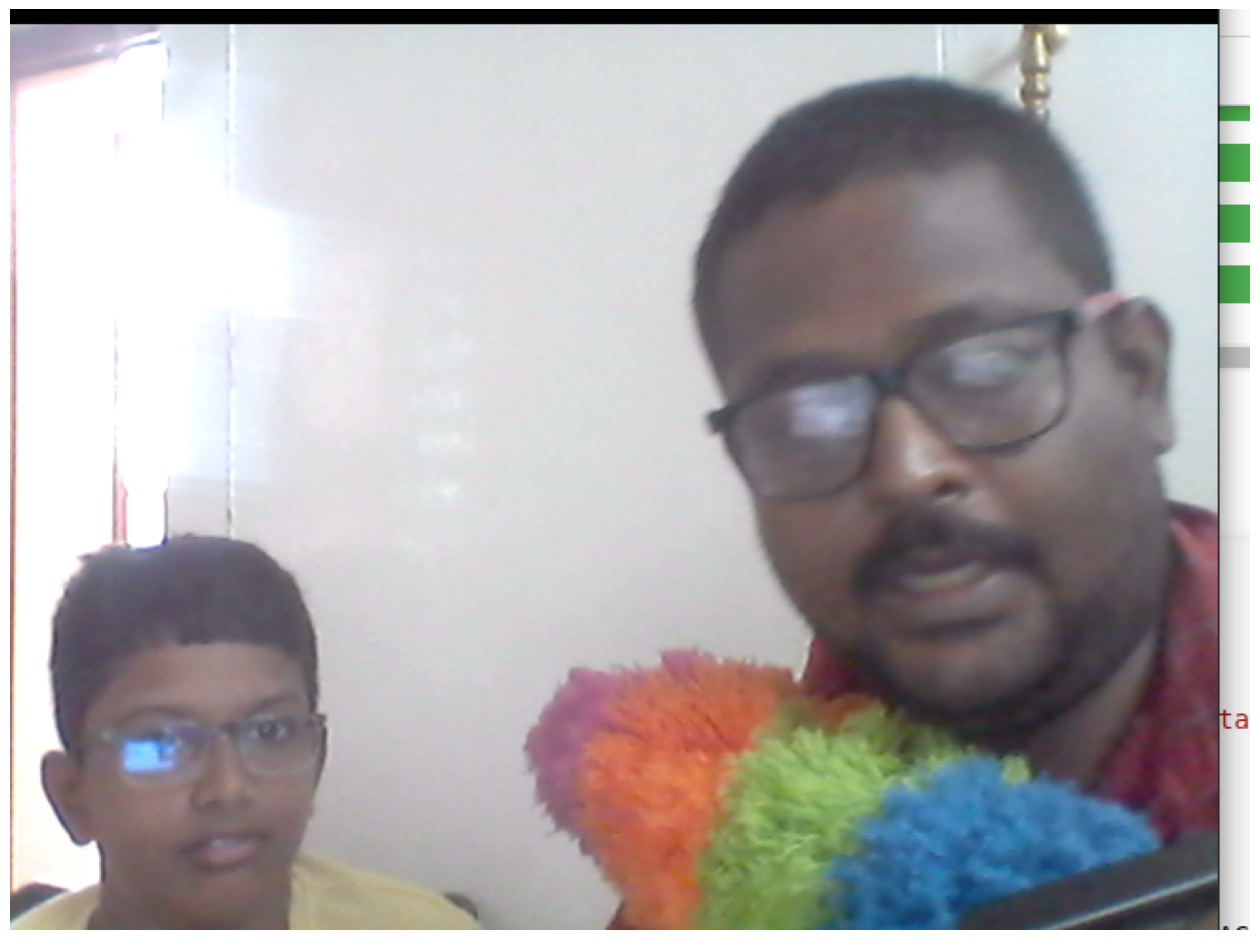

In [23]:
import os
import supervision as sv

IMAGE_NAME = "/content/hghfh.png"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

TEXT_PROMPT = "boy with spectacles"
BOX_TRESHOLD = 0.4
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

## Object Detection (parachutes)

In [ ]:
import os
import supervision as sv

IMAGE_NAME = "air.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

TEXT_PROMPT = "parachutes"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [ ]:
import os
import supervision as sv

IMAGE_NAME = "ocean.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

TEXT_PROMPT = "surfers"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [ ]:
import os
import supervision as sv
import time

IMAGE_NAME = "snow.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

TEXT_PROMPT = "snowboarder"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)
start = time.time()
boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)
end = time.time()
print(end - start)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))